In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

# For time series features
from tqdm import tqdm
import datetime as dt
import time

# Install IBL library
!pip install ibllib

# Connecting to IBL database
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

# Check connection status
print(f"Connected to the database: {one.alyx.user}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.3/993.3 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 29.9 MB/s eta

In [ ]:
# Query all sessions with the biasedChoiceWorld task
sessions = one.alyx.rest('sessions', 'list', task_protocol='biasedChoiceWorld')
print(f"Found {len(sessions)} biasedChoiceWorld sessions")

# Count sessions per subject
subject_counts = {}
for sess in sessions:
    subject = sess['subject']
    if subject in subject_counts:
        subject_counts[subject] += 1
    else:
        subject_counts[subject] = 1

# Find subjects with many sessions
subject_series = pd.Series(subject_counts)
subjects_with_many_sessions = subject_series[subject_series > 10].sort_values(ascending=False)
print("Top 5 subjects by number of sessions:")
print(subjects_with_many_sessions.head())

# Select a subject with many sessions
target_subject = subjects_with_many_sessions.index[0]
print(f"\nSelected subject {target_subject} with {subjects_with_many_sessions[target_subject]} sessions")

# Get all sessions for that subject
subject_sessions = one.alyx.rest('sessions', 'list', subject=target_subject, task_protocol='biasedChoiceWorld')
print(f"Found {len(subject_sessions)} sessions for subject {target_subject}")


Found 2901 biasedChoiceWorld sessions
Top 5 subjects by number of sessions:
ibl_witten_12    81
ibl_witten_07    68
ibl_witten_16    66
KS019            65
ibl_witten_14    61
dtype: int64

Selected subject ibl_witten_12 with 81 sessions
Found 81 sessions for subject ibl_witten_12


In [ ]:
def extract_session_trials(session):
    """
    Extract trial data for a single session (takes full session dictionary).
    Handles missing fields safely.
    """
    import numpy as np
    import pandas as pd

    try:
        eid = session['id']
        trials = one.load_object(eid, 'trials')

        # Helper function to safely extract a field or return NaNs
        def safe_get(trials, key, fill=np.nan):
            return trials[key] if key in trials else np.full(len(trials['feedbackType']), fill)

        trial_data = {
            'eid': eid,
            'subject': session.get('subject', 'unknown'),
            'date': session.get('start_time', '')[:10],
            'trial_id': np.arange(len(trials['feedbackType'])),
            'feedback_type': trials['feedbackType'],
            'reaction_time': safe_get(trials, 'response_times'),
            'trial_start_times': trials['intervals'][:, 0],
            'trial_end_times': trials['intervals'][:, 1],
            'choice': safe_get(trials, 'choice'),
            'trial_contrast': (
                trials['contrastLeft']
                if np.nansum(trials['contrastLeft']) > np.nansum(trials['contrastRight'])
                else trials['contrastRight']
            ),
        }

        # Compute inter-trial intervals
        trial_data['inter_trial_interval'] = np.diff(
            trial_data['trial_start_times'], prepend=trial_data['trial_start_times'][0]
        )

        # Create dataframe
        df = pd.DataFrame(trial_data)
        df['success'] = (df['feedback_type'] > 0).astype(int)
        df['cumulative_success'] = df['success'].cumsum()
        df['rolling_success_rate'] = df['success'].rolling(window=10, min_periods=1).mean()
        df['time_in_session'] = (df['trial_start_times'] - df['trial_start_times'].iloc[0]) / 60

        return df

    except Exception as e:
        print(f"Error processing session {session.get('id', 'unknown')}: {e}")
        return None


all_sessions_data = []
for i, session in enumerate(tqdm(subject_sessions[:20])):  # session is a dict
    df = extract_session_trials(session)
    if df is not None:
        all_sessions_data.append(df)
        print(f"Session {i+1}: {len(df)} trials extracted")

combined_df = pd.concat(all_sessions_data, ignore_index=True)
print(f"Total trials across all sessions: {len(combined_df)}")
combined_df.head()


  0%|          | 0/20 [00:00<?, ?it/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-22/001/alf/_ibl_trials.table.pqt:   0%|          | 0.00/70.9k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 70.9k/70.9k [00:00<00:00, 466kB/s]
  5%|▌         | 1/20 [00:02<00:42,  2.23s/it]

Session 1: 932 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-21/003/alf/_ibl_trials.table.pqt:   0%|          | 0.00/91.2k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-21/003/alf/_ibl_trials.table.pqt: 100%|██████████| 91.2k/91.2k [00:00<00:00, 463kB/s]
 10%|█         | 2/20 [00:03<00:33,  1.84s/it]

Session 2: 1209 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-20/001/alf/_ibl_trials.table.pqt:   0%|          | 0.00/76.4k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-20/001/alf/_ibl_trials.table.pqt: 100%|██████████| 76.4k/76.4k [00:00<00:00, 380kB/s]
 15%|█▌        | 3/20 [00:05<00:26,  1.58s/it]

Session 3: 1001 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-19/001/alf/_ibl_trials.goCue_times.npy:   0%|          | 0.00/9.68k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-19/001/alf/_ibl_trials.goCue_times.npy: 100%|██████████| 9.68k/9.68k [00:00<00:00, 81.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-19/001/alf/_ibl_trials.feedback_times.npy:   0%|          | 0.00/9.68k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-19/001/alf/_ibl_trials.feedback_times.npy: 100%|██████████| 9.68k/9.68k [00:00<00:00, 76.6kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-19/001/alf/_ibl_trials.response_times.npy:   0%|          | 0.00/9.68k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internation

Session 4: 1194 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-18/001/alf/_ibl_trials.feedbackType.npy: 100%|██████████| 9.27k/9.27k [00:00<00:00, 97.0kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-18/001/alf/_ibl_trials.contrastLeft.npy:   0%|          | 0.00/9.27k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-18/001/alf/_ibl_trials.contrastLeft.npy: 100%|██████████| 9.27k/9.27k [00:00<00:00, 53.2kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-18/001/alf/_ibl_trials.probabilityLeft.npy:   0%|          | 0.00/9.27k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-18/001/alf/_ibl_trials.probabilityLeft.npy: 100%|██████████| 9.27k/9.27k [00:00<00:00, 84.1kB/s]

(S3) /root/Downloads/ONE/openalyx

Session 5: 1143 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-15/001/alf/_ibl_trials.stimOn_times.npy: 100%|██████████| 7.54k/7.54k [00:00<00:00, 81.9kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-15/001/alf/_ibl_trials.intervals.npy:   0%|          | 0.00/14.9k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-15/001/alf/_ibl_trials.intervals.npy: 100%|██████████| 14.9k/14.9k [00:00<00:00, 141kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-15/001/alf/_ibl_trials.response_times.npy:   0%|          | 0.00/7.54k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-15/001/alf/_ibl_trials.response_times.npy: 100%|██████████| 7.54k/7.54k [00:00<00:00, 68.0kB/s]

(S3) /root/Downloads/ONE/openalyx.internat

Session 6: 926 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-14/001/alf/_ibl_trials.goCue_times.npy: 100%|██████████| 7.82k/7.82k [00:00<00:00, 84.7kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-14/001/alf/_ibl_trials.intervals.npy:   0%|          | 0.00/15.5k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-14/001/alf/_ibl_trials.intervals.npy: 100%|██████████| 15.5k/15.5k [00:00<00:00, 141kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-14/001/alf/_ibl_trials.contrastLeft.npy:   0%|          | 0.00/7.82k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-14/001/alf/_ibl_trials.contrastLeft.npy: 100%|██████████| 7.82k/7.82k [00:00<00:00, 69.8kB/s]

(S3) /root/Downloads/ONE/openalyx.international

Session 7: 962 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-13/001/alf/_ibl_trials.goCue_times.npy:   0%|          | 0.00/10.1k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-13/001/alf/_ibl_trials.goCue_times.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 83.5kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-13/001/alf/_ibl_trials.feedbackType.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 105kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-13/001/alf/_ibl_trials.contrastRight.npy:   0%|          | 0.00/10.1k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-13/001/alf/_ibl_trials.contrastRight.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 85.8kB/s]

(S3) /root/Downloads/ONE/openalyx.intern

Session 8: 1245 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-12/001/alf/_ibl_trials.feedback_times.npy:   0%|          | 0.00/9.66k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-12/001/alf/_ibl_trials.feedback_times.npy: 100%|██████████| 9.66k/9.66k [00:00<00:00, 80.7kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-12/001/alf/_ibl_trials.feedbackType.npy:   0%|          | 0.00/9.66k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-12/001/alf/_ibl_trials.feedbackType.npy: 100%|██████████| 9.66k/9.66k [00:00<00:00, 87.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-12/001/alf/_ibl_trials.contrastRight.npy:   0%|          | 0.00/9.66k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internatio

Session 9: 1191 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-11/001/alf/_ibl_trials.feedbackType.npy:   0%|          | 0.00/10.6k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-11/001/alf/_ibl_trials.feedbackType.npy: 100%|██████████| 10.6k/10.6k [00:00<00:00, 97.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-11/001/alf/_ibl_trials.stimOn_times.npy:   0%|          | 0.00/10.6k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-11/001/alf/_ibl_trials.stimOn_times.npy: 100%|██████████| 10.6k/10.6k [00:00<00:00, 86.9kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-11/001/alf/_ibl_trials.response_times.npy:   0%|          | 0.00/10.6k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.international

Session 10: 1311 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-08/001/alf/_ibl_trials.goCue_times.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 103kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-08/001/alf/_ibl_trials.response_times.npy:   0%|          | 0.00/10.1k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-08/001/alf/_ibl_trials.response_times.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 92.8kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-08/001/alf/_ibl_trials.intervals.npy:   0%|          | 0.00/20.1k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-08/001/alf/_ibl_trials.intervals.npy: 100%|██████████| 20.1k/20.1k [00:00<00:00, 183kB/s]

(S3) /root/Downloads/ONE/openalyx.internatio

Session 11: 1247 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-07/001/alf/_ibl_trials.feedback_times.npy: 100%|██████████| 9.76k/9.76k [00:00<00:00, 98.9kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-07/001/alf/_ibl_trials.response_times.npy:   0%|          | 0.00/9.76k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-07/001/alf/_ibl_trials.response_times.npy: 100%|██████████| 9.76k/9.76k [00:00<00:00, 67.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-07/001/alf/_ibl_trials.probabilityLeft.npy:   0%|          | 0.00/9.76k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-07/001/alf/_ibl_trials.probabilityLeft.npy: 100%|██████████| 9.76k/9.76k [00:00<00:00, 88.9kB/s]

(S3) /root/Downloads/ONE/op

Session 12: 1204 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-06/001/alf/_ibl_trials.choice.npy: 100%|██████████| 10.2k/10.2k [00:00<00:00, 125kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-06/001/alf/_ibl_trials.contrastRight.npy: 100%|██████████| 10.2k/10.2k [00:00<00:00, 116kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-06/001/alf/_ibl_trials.feedbackType.npy:   0%|          | 0.00/10.2k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-06/001/alf/_ibl_trials.feedbackType.npy: 100%|██████████| 10.2k/10.2k [00:00<00:00, 74.9kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-06/001/alf/_ibl_trials.probabilityLeft.npy: 100%|██████████| 10.2k/10.2k [00:00<00:00, 115kB/s]

(S3) /root/Downloads/ONE/openalyx.

Session 13: 1254 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-05/001/alf/_ibl_trials.feedback_times.npy:   0%|          | 0.00/3.75k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-05/001/alf/_ibl_trials.feedback_times.npy: 100%|██████████| 3.75k/3.75k [00:00<00:00, 28.5kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-05/001/alf/_ibl_trials.contrastRight.npy: 100%|██████████| 3.75k/3.75k [00:00<00:00, 42.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-05/001/alf/_ibl_trials.probabilityLeft.npy: 100%|██████████| 3.75k/3.75k [00:00<00:00, 38.9kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-05/001/alf/_ibl_trials.feedbackType.npy: 100%|██████████| 3.75k/3.75k [00:00<00:00, 38.9kB/s]

(S3) /root/Downloads/

Session 14: 453 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-04/005/alf/_ibl_trials.response_times.npy: 100%|██████████| 7.30k/7.30k [00:00<00:00, 72.6kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-04/005/alf/_ibl_trials.probabilityLeft.npy:   0%|          | 0.00/7.30k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-04/005/alf/_ibl_trials.probabilityLeft.npy: 100%|██████████| 7.30k/7.30k [00:00<00:00, 65.7kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-04/005/alf/_ibl_trials.choice.npy:   0%|          | 0.00/7.30k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-04/005/alf/_ibl_trials.choice.npy: 100%|██████████| 7.30k/7.30k [00:00<00:00, 21.1kB/s]

(S3) /root/Downloads/ONE/openalyx.internati

Session 15: 896 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-01/001/alf/_ibl_trials.response_times.npy:   0%|          | 0.00/9.85k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-01/001/alf/_ibl_trials.response_times.npy: 100%|██████████| 9.85k/9.85k [00:00<00:00, 76.3kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-01/001/alf/_ibl_trials.choice.npy: 100%|██████████| 9.85k/9.85k [00:00<00:00, 103kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-01/001/alf/_ibl_trials.intervals.npy: 100%|██████████| 19.6k/19.6k [00:00<00:00, 210kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-11-01/001/alf/_ibl_trials.contrastRight.npy:   0%|          | 0.00/9.85k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internation

Session 16: 1215 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-31/001/alf/_ibl_trials.goCue_times.npy:   0%|          | 0.00/9.92k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-31/001/alf/_ibl_trials.goCue_times.npy: 100%|██████████| 9.92k/9.92k [00:00<00:00, 73.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-31/001/alf/_ibl_trials.choice.npy: 100%|██████████| 9.92k/9.92k [00:00<00:00, 108kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-31/001/alf/_ibl_trials.contrastLeft.npy:   0%|          | 0.00/9.92k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-31/001/alf/_ibl_trials.contrastLeft.npy: 100%|██████████| 9.92k/9.92k [00:00<00:00, 73.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalb

Session 17: 1224 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-30/001/alf/_ibl_trials.stimOn_times.npy:   0%|          | 0.00/9.18k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-30/001/alf/_ibl_trials.stimOn_times.npy: 100%|██████████| 9.18k/9.18k [00:00<00:00, 62.5kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-30/001/alf/_ibl_trials.probabilityLeft.npy: 100%|██████████| 9.18k/9.18k [00:00<00:00, 99.4kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-30/001/alf/_ibl_trials.goCue_times.npy:   0%|          | 0.00/9.18k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-30/001/alf/_ibl_trials.goCue_times.npy: 100%|██████████| 9.18k/9.18k [00:00<00:00, 50.7kB/s]

(S3) /root/Downloads/ONE/openalyx.inte

Session 18: 1132 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-29/001/alf/_ibl_trials.contrastRight.npy:   0%|          | 0.00/9.65k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-29/001/alf/_ibl_trials.contrastRight.npy: 100%|██████████| 9.65k/9.65k [00:00<00:00, 86.8kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-29/001/alf/_ibl_trials.response_times.npy: 100%|██████████| 9.65k/9.65k [00:00<00:00, 99.8kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-29/001/alf/_ibl_trials.contrastLeft.npy: 100%|██████████| 9.65k/9.65k [00:00<00:00, 96.9kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-29/001/alf/_ibl_trials.feedbackType.npy: 100%|██████████| 9.65k/9.65k [00:00<00:00, 103kB/s]

(S3) /root/Downloads/ONE/o

Session 19: 1190 trials extracted



(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-28/001/alf/_ibl_trials.response_times.npy:   0%|          | 0.00/10.1k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-28/001/alf/_ibl_trials.response_times.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 89.9kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-28/001/alf/_ibl_trials.contrastRight.npy:   0%|          | 0.00/10.1k [00:00<?, ?B/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-28/001/alf/_ibl_trials.contrastRight.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 96.1kB/s]

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_12/2019-10-28/001/alf/_ibl_trials.contrastLeft.npy: 100%|██████████| 10.1k/10.1k [00:00<00:00, 113kB/s]

(S3) /root/Downloads/ONE/openalyx.

Session 20: 1252 trials extracted
Total trials across all sessions: 22181


,eid,subject,date,trial_id,feedback_type,reaction_time,trial_start_times,trial_end_times,choice,trial_contrast,inter_trial_interval,success,cumulative_success,rolling_success_rate,time_in_session
0,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,0,1.0,906.018900,0.000000,907.518901,1.0,NaN,0.000000,1,1,1.0,0.000000
1,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,1,1.0,915.977199,913.523699,917.477201,-1.0,0.25,913.523699,1,2,1.0,15.225395
2,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,2,1.0,919.110399,917.879999,920.610401,-1.0,0.25,4.356300,1,3,1.0,15.298000
3,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,3,1.0,922.316899,920.987199,923.816901,1.0,NaN,3.107200,1,4,1.0,15.349787
4,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,4,1.0,929.855699,924.203199,931.355701,1.0,NaN,3.216000,1,5,1.0,15.403387


In [ ]:
def engineer_boredom_features(session_df):
    """Engineer features that may indicate boredom/disengagement"""
    # Make a copy to avoid modifying the original
    df = session_df.copy()

    # 1. Smoothed reaction time (higher = potentially more bored)
    df['smooth_rt'] = df['reaction_time'].rolling(window=10, min_periods=1).mean()

    # 2. Smoothed inter-trial interval (higher = potentially more bored)
    df['smooth_iti'] = df['inter_trial_interval'].rolling(window=10, min_periods=1).mean()

    # 3. Performance drop (rolling accuracy change - negative means dropping performance)
    df['perf_change'] = df['rolling_success_rate'].diff()

    # 4. Trial skip rate (approximated by longer ITIs)
    # Define a threshold for "long" ITIs (e.g., 2x the median)
    iti_threshold = df['inter_trial_interval'].median() * 2
    df['skip_trial'] = (df['inter_trial_interval'] > iti_threshold).astype(int)
    df['skip_rate'] = df['skip_trial'].rolling(window=10, min_periods=1).mean()

    # 5. Engagement consistency (variability in reaction time - higher = less consistent)
    df['rt_variability'] = df['reaction_time'].rolling(window=10, min_periods=1).std()

    # 6. Time progression through session (normalized 0-1)
    if len(df) > 0:
        df['session_progress'] = (df['time_in_session'] - df['time_in_session'].min()) / \
                              (df['time_in_session'].max() - df['time_in_session'].min())
    else:
        df['session_progress'] = 0

    return df

# Apply feature engineering to each session
processed_sessions = []
for i, eid in enumerate(combined_df['eid'].unique()):
    # Get data for this session
    session_df = combined_df[combined_df['eid'] == eid].copy()

    # Engineer features
    processed_df = engineer_boredom_features(session_df)

    # Add session_id
    processed_df['session_id'] = i

    processed_sessions.append(processed_df)

# Combine processed sessions
processed_df = pd.concat(processed_sessions, ignore_index=True)

# Fill NaN values
processed_df = processed_df.fillna(0)

# Show resulting dataframe
processed_df.head()

,eid,subject,date,trial_id,feedback_type,reaction_time,trial_start_times,trial_end_times,choice,trial_contrast,...,rolling_success_rate,time_in_session,smooth_rt,smooth_iti,perf_change,skip_trial,skip_rate,rt_variability,session_progress,session_id
0,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,0,1.0,906.018900,0.000000,907.518901,1.0,0.00,...,1.0,0.000000,906.018900,0.000000,0.0,0,0.000000,0.000000,0.000000,0
1,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,1,1.0,915.977199,913.523699,917.477201,-1.0,0.25,...,1.0,15.225395,910.998049,456.761849,0.0,1,0.500000,7.041581,0.166200,0
2,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,2,1.0,919.110399,917.879999,920.610401,-1.0,0.25,...,1.0,15.298000,913.702166,305.960000,0.0,0,0.333333,6.835837,0.166993,0
3,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,3,1.0,922.316899,920.987199,923.816901,1.0,0.00,...,1.0,15.349787,915.855849,230.246800,0.0,0,0.250000,7.050238,0.167558,0
4,14a03fbd-ba69-4d44-a901-39d86529a3be,ibl_witten_12,2019-11-22,4,1.0,929.855699,924.203199,931.355701,1.0,0.00,...,1.0,15.403387,918.655819,184.840640,0.0,0,0.200000,8.745201,0.168143,0


In [ ]:
def compute_boredom_score(df):
    """
    Compute a continuous boredom score based on behavioral features.
    Higher score = more disengaged/bored
    """
    # Normalize features to 0-1 scale for each session
    normalized_df = df.copy()

    for session_id in df['session_id'].unique():
        session_mask = df['session_id'] == session_id
        session_data = df[session_mask]

        # List of features to normalize
        features_to_normalize = ['smooth_rt', 'smooth_iti', 'rt_variability', 'skip_rate']

        for feature in features_to_normalize:
            min_val = session_data[feature].min()
            max_val = session_data[feature].max()

            # Avoid division by zero
            if max_val > min_val:
                normalized_df.loc[session_mask, f'norm_{feature}'] = (session_data[feature] - min_val) / (max_val - min_val)
            else:
                normalized_df.loc[session_mask, f'norm_{feature}'] = 0.5  # Default to middle value

    # Calculate boredom score as weighted sum of normalized features
    # Higher reaction time -> more bored
    # Higher ITI -> more bored
    # Higher reaction time variability -> more bored
    # Higher skip rate -> more bored
    # Lower rolling success rate -> more bored

    normalized_df['boredom_score'] = (
        0.3 * normalized_df['norm_smooth_rt'] +
        0.2 * normalized_df['norm_smooth_iti'] +
        0.2 * normalized_df['norm_rt_variability'] +
        0.2 * normalized_df['norm_skip_rate'] +
        0.1 * (1 - normalized_df['rolling_success_rate'])
    )

    # Smooth the boredom score
    normalized_df['boredom_score_smooth'] = normalized_df.groupby('session_id')['boredom_score'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    return normalized_df

# Compute boredom score
boredom_df = compute_boredom_score(processed_df)

# Display sample results
boredom_df[['session_id', 'trial_id', 'reaction_time',
            'inter_trial_interval', 'rolling_success_rate',
            'boredom_score', 'boredom_score_smooth']].head(10)

,session_id,trial_id,reaction_time,inter_trial_interval,rolling_success_rate,boredom_score,boredom_score_smooth
0,0,0,906.018900,0.000000,1.0,0.000000,0.000000
1,0,1,915.977199,913.523699,1.0,0.354281,0.177141
2,0,2,919.110399,4.356300,1.0,0.240488,0.198256
3,0,3,922.316899,3.107200,1.0,0.184008,0.194694
4,0,4,929.855699,3.216000,1.0,0.152697,0.186295
5,0,5,932.661299,7.655300,1.0,0.179504,0.185163
6,0,6,936.220699,2.699600,1.0,0.157859,0.181262
7,0,7,939.346899,3.559300,1.0,0.141888,0.176340
8,0,8,945.110799,3.121000,1.0,0.130402,0.171236
9,0,9,948.768899,5.778700,1.0,0.121578,0.166270


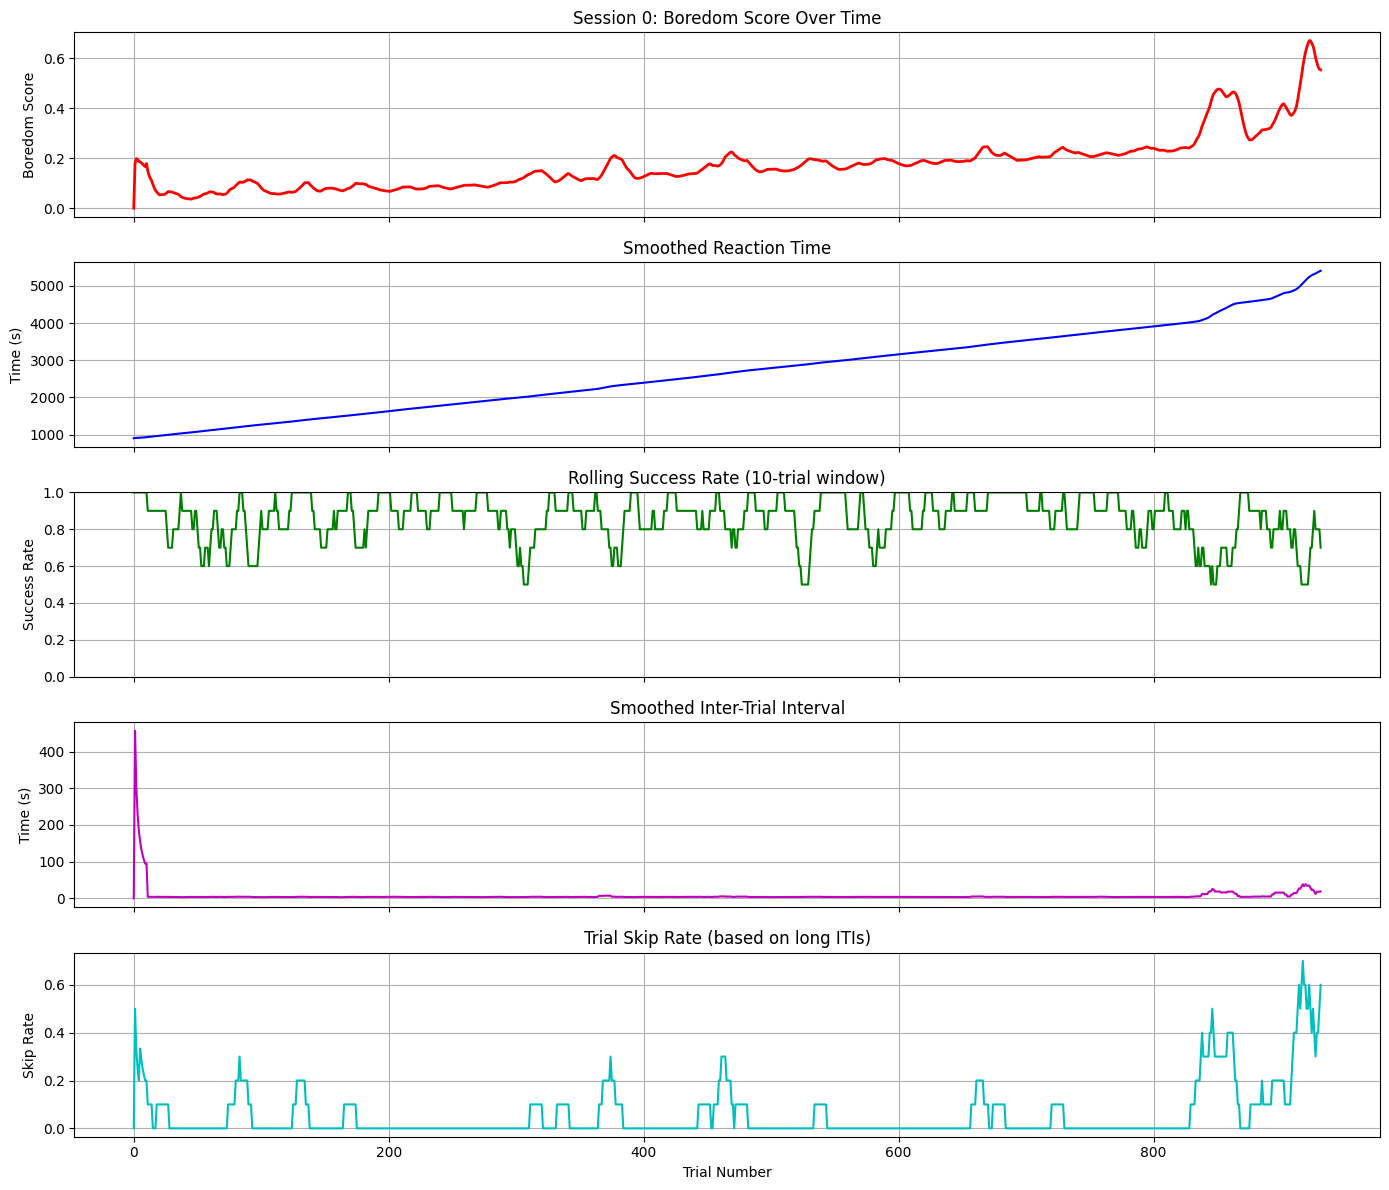

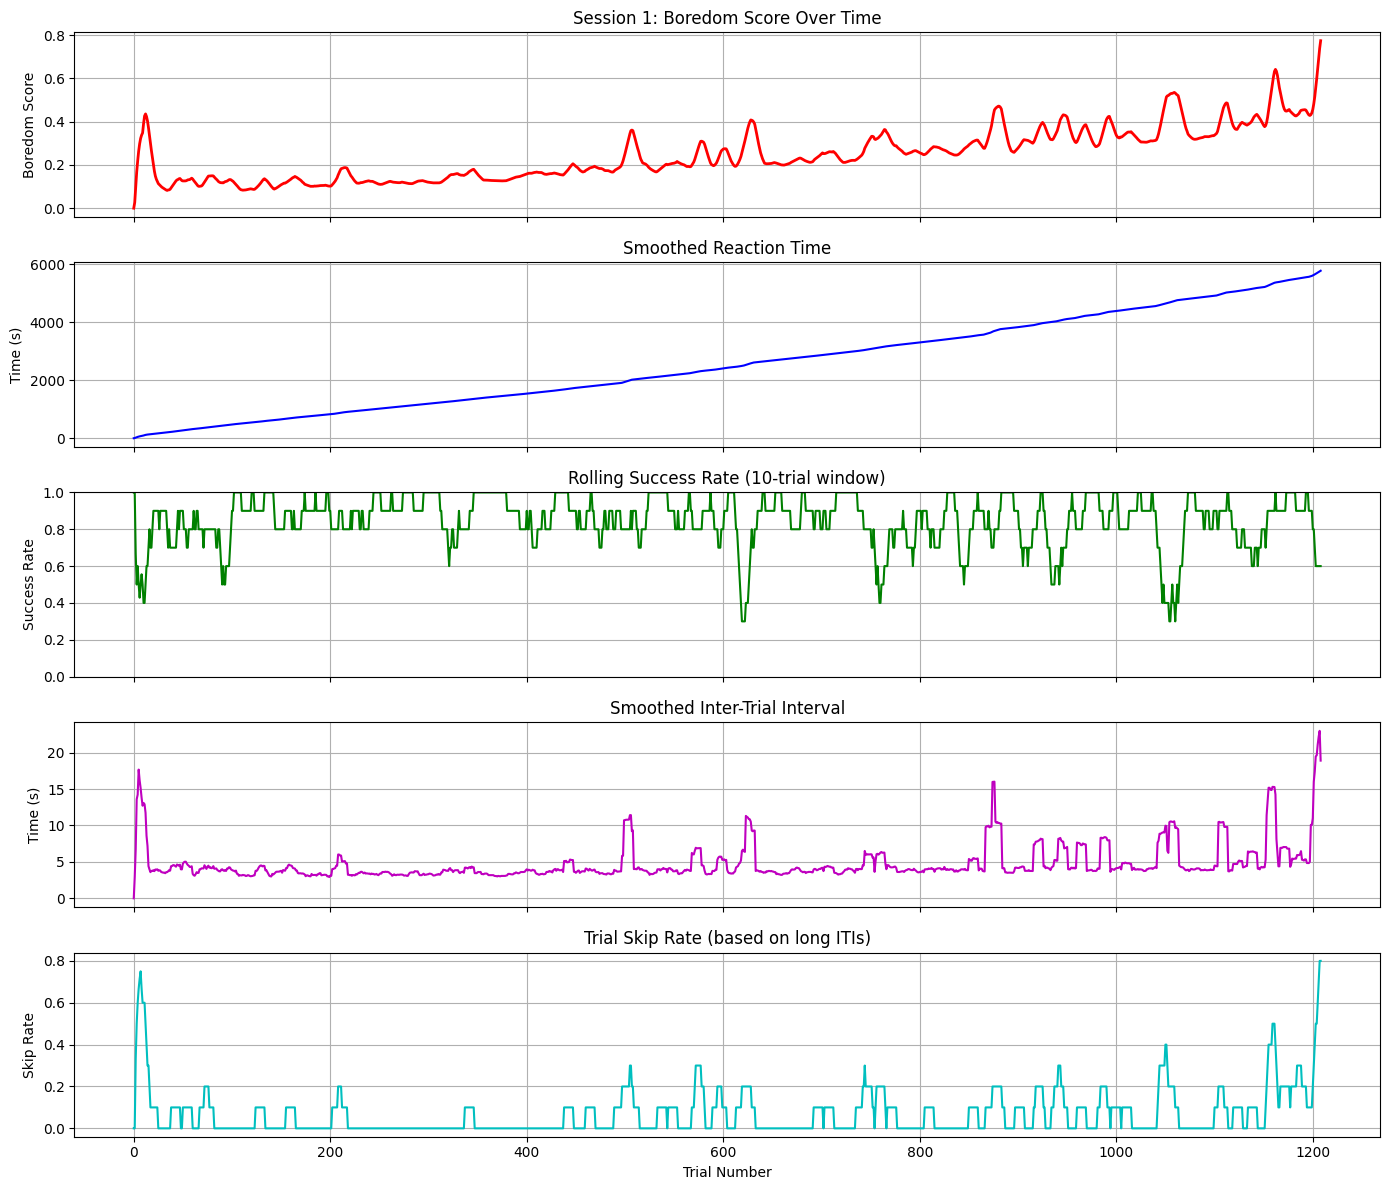

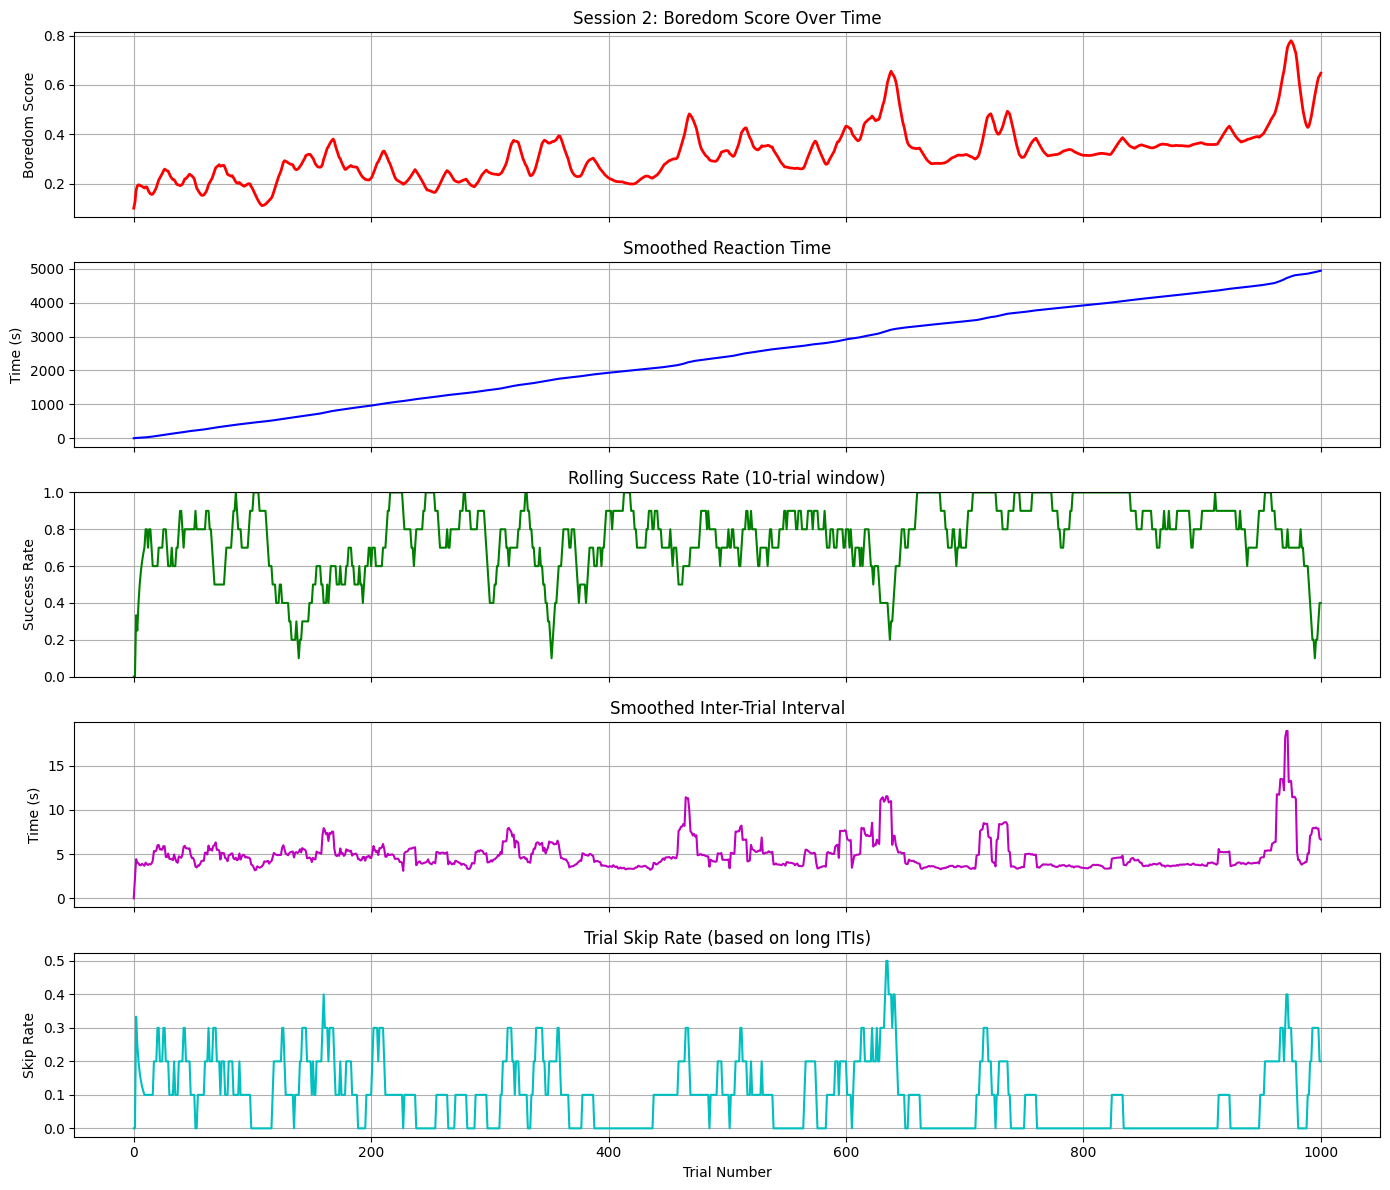

In [ ]:
def plot_session_boredom(df, session_id):
    """Plot boredom indicators for a single session"""
    session_data = df[df['session_id'] == session_id]

    fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

    # Plot 1: Boredom score over time
    axes[0].plot(session_data['trial_id'], session_data['boredom_score_smooth'], 'r-', linewidth=2)
    axes[0].set_title(f'Session {session_id}: Boredom Score Over Time')
    axes[0].set_ylabel('Boredom Score')
    axes[0].grid(True)

    # Plot 2: Reaction time
    axes[1].plot(session_data['trial_id'], session_data['smooth_rt'], 'b-')
    axes[1].set_title('Smoothed Reaction Time')
    axes[1].set_ylabel('Time (s)')
    axes[1].grid(True)

    # Plot 3: Success rate
    axes[2].plot(session_data['trial_id'], session_data['rolling_success_rate'], 'g-')
    axes[2].set_title('Rolling Success Rate (10-trial window)')
    axes[2].set_ylabel('Success Rate')
    axes[2].set_ylim([0, 1])
    axes[2].grid(True)

    # Plot 4: Inter-trial interval
    axes[3].plot(session_data['trial_id'], session_data['smooth_iti'], 'm-')
    axes[3].set_title('Smoothed Inter-Trial Interval')
    axes[3].set_ylabel('Time (s)')
    axes[3].grid(True)

    # Plot 5: Skip rate
    axes[4].plot(session_data['trial_id'], session_data['skip_rate'], 'c-')
    axes[4].set_title('Trial Skip Rate (based on long ITIs)')
    axes[4].set_xlabel('Trial Number')
    axes[4].set_ylabel('Skip Rate')
    axes[4].grid(True)

    plt.tight_layout()
    plt.show()

# Plot for first 3 sessions
for session_id in range(3):
    plot_session_boredom(boredom_df, session_id)

In [ ]:
def prepare_model_data(df):
    """Prepare features and target for ML model"""

    # Features for predicting boredom
    features = [
        'reaction_time', 'inter_trial_interval', 'rt_variability',
        'rolling_success_rate', 'skip_rate', 'session_progress'
    ]

    # Add lag features (previous trial information)
    for feature in features.copy():
        for lag in [1, 2, 3]:  # Use information from previous 3 trials
            lagged_feature = f"{feature}_lag{lag}"
            df[lagged_feature] = df.groupby('session_id')[feature].shift(lag)

    # Fill NaN values that occur at the beginning of sessions
    df = df.fillna(0)

    # Target variable
    target = 'boredom_score_smooth'

    # Updated feature list including lagged features
    all_features = [col for col in df.columns if any(f == col or f"_{col.split('_')[0]}" in col for f in features)]

    # Prepare X and y
    X = df[all_features]
    y = df[target]

    return X, y

# Prepare model data
X, y = prepare_model_data(boredom_df)

# Split data by sessions (not randomly)
train_sessions = boredom_df['session_id'].unique()[:-5]  # Use all but last 5 sessions for training
test_sessions = boredom_df['session_id'].unique()[-5:]   # Use last 5 sessions for testing

# Create train/test sets
train_mask = boredom_df['session_id'].isin(train_sessions)
test_mask = boredom_df['session_id'].isin(test_sessions)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 16168 samples
Testing set: 6013 samples


In [ ]:
# Create pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
print("Training boredom prediction model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate model
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Model performance:")
print(f"Training MAE: {train_mae:.4f}")
print(f"Testing MAE: {test_mae:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

# Display top 10 features
print("\nTop 10 most important features:")
print(feature_importance.head(10))

Training boredom prediction model...
Model performance:
Training MAE: 0.0153
Testing MAE: 0.0674

Top 10 most important features:
                     feature  importance
5           session_progress    0.540773
4             rt_variability    0.155638
0              reaction_time    0.113231
1       inter_trial_interval    0.036427
6  inter_trial_interval_lag1    0.033849
7  inter_trial_interval_lag2    0.033153
3                  skip_rate    0.032961
8  inter_trial_interval_lag3    0.031641
2       rolling_success_rate    0.022327


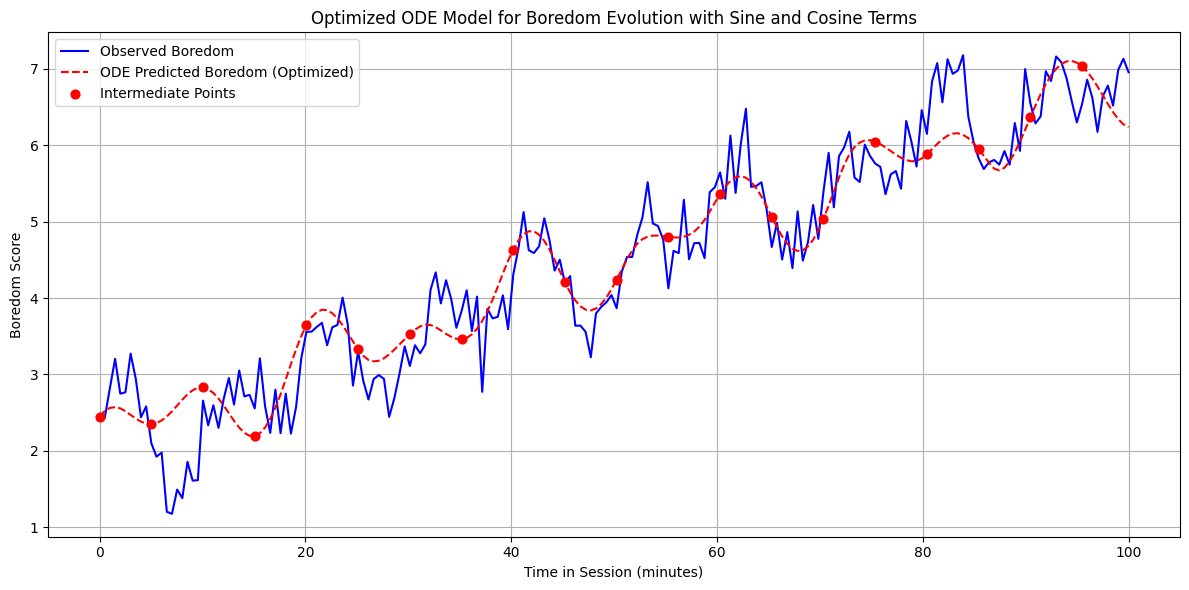

Classification Report (High vs. Low Boredom):
              precision    recall  f1-score   support

 Low Boredom       0.94      0.97      0.95       162
High Boredom       0.85      0.74      0.79        38

    accuracy                           0.93       200
   macro avg       0.89      0.85      0.87       200
weighted avg       0.92      0.93      0.92       200

Confusion Matrix:
[[157   5]
 [ 10  28]]


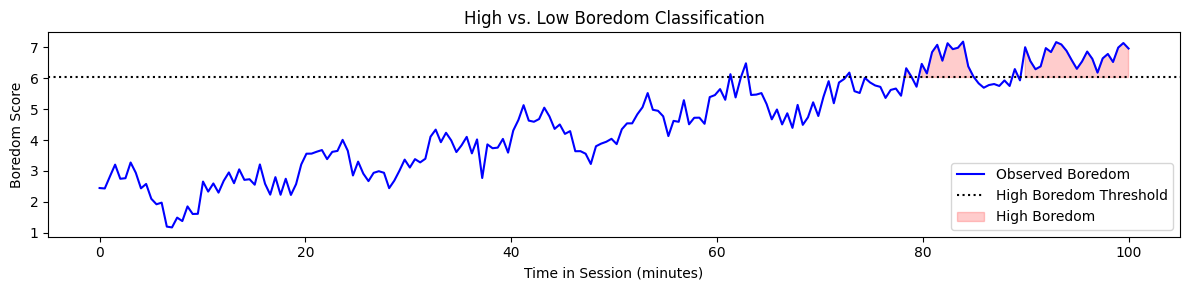

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Simulate session data (replace with your real data if available)
np.random.seed(42)
times = np.linspace(0, 100, 200)
observed_boredom = (
    2
    + 0.05 * times
    + 0.5 * np.sin(2 * np.pi * 0.1 * times)
    + 0.3 * np.cos(2 * np.pi * 0.05 * times)
    + np.random.normal(0, 0.3, len(times))
)
smooth_rt = np.ones_like(times)  # Dummy constant reaction time
rolling_success_rate = 0.5 + 0.4 * np.sin(2 * np.pi * 0.1 * times)  # Simulated success rate

# 2. Interpolation functions
rt_func = interp1d(times, smooth_rt, bounds_error=False, fill_value="extrapolate")
success_func = interp1d(times, rolling_success_rate, bounds_error=False, fill_value="extrapolate")

# 3. ODE model with oscillations
def boredom_ode_model_with_oscillations(t, y, params):
    base_rate = params['base_rate']
    recovery_rate = params['recovery_rate']
    time_weight = params['time_weight']
    damping = params['damping']
    current_success = params['success_func'](t)
    session_length = len(params['t']) if 't' in params and len(params['t']) > 0 else 1

    freq1 = params.get('freq1', 0.1)
    freq2 = params.get('freq2', 0.05)
    amp1 = params.get('amp1', 0.5)
    amp2 = params.get('amp2', 0.3)

    oscillation_term = amp1 * np.sin(2 * np.pi * freq1 * t) + amp2 * np.cos(2 * np.pi * freq2 * t)

    dydt = (
        base_rate
        + time_weight * (t / session_length)
        - recovery_rate * current_success
        - damping * y
        + oscillation_term
    )

    if y <= 0 and dydt < 0:
        dydt = 0

    return dydt

# 4. Loss function for optimization
def loss(params_array):
    base_rate, recovery_rate, time_weight, damping, amp1, amp2, freq1, freq2 = params_array
    params = {
        'base_rate': base_rate,
        'recovery_rate': recovery_rate,
        'time_weight': time_weight,
        'damping': damping,
        'rt_func': rt_func,
        'success_func': success_func,
        't': times,
        'amp1': amp1,
        'amp2': amp2,
        'freq1': freq1,
        'freq2': freq2
    }
    y0 = [observed_boredom[0]]
    sol = solve_ivp(
        lambda t, y: boredom_ode_model_with_oscillations(t, y, params),
        [times[0], times[-1]],
        y0,
        t_eval=times,
        method='RK45'
    )
    ode_boredom = sol.y[0]
    return np.mean((ode_boredom - observed_boredom) ** 2)

# 5. Optimize parameters
init_params = [0.05, 0.005, 0.02, 0.005, 0.5, 0.3, 0.1, 0.05]
result = minimize(loss, init_params, method='Nelder-Mead')
opt_params = result.x

# 6. Solve ODE with optimized parameters
params_opt = {
    'base_rate': opt_params[0],
    'recovery_rate': opt_params[1],
    'time_weight': opt_params[2],
    'damping': opt_params[3],
    'rt_func': rt_func,
    'success_func': success_func,
    't': times,
    'amp1': opt_params[4],
    'amp2': opt_params[5],
    'freq1': opt_params[6],
    'freq2': opt_params[7]
}
y0 = [observed_boredom[0]]
solution_opt = solve_ivp(
    lambda t, y: boredom_ode_model_with_oscillations(t, y, params_opt),
    [times[0], times[-1]],
    y0,
    t_eval=times,
    method='RK45'
)
predicted_boredom = solution_opt.y[0]

# 7. Plot observed vs. predicted boredom
plt.figure(figsize=(12, 6))
plt.plot(times, observed_boredom, 'b-', label='Observed Boredom')
plt.plot(times, predicted_boredom, 'r--', label='ODE Predicted Boredom (Optimized)')
plt.scatter(times[::10], predicted_boredom[::10], color='red', s=40, zorder=5, label='Intermediate Points')
plt.title('Optimized ODE Model for Boredom Evolution with Sine and Cosine Terms')
plt.xlabel('Time in Session (minutes)')
plt.ylabel('Boredom Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Classify high vs. low boredom states
threshold = np.mean(observed_boredom) + np.std(observed_boredom)
true_labels = (observed_boredom > threshold).astype(int)
pred_labels = (predicted_boredom > threshold).astype(int)

# 9. Evaluate classification
print("Classification Report (High vs. Low Boredom):")
print(classification_report(true_labels, pred_labels, target_names=["Low Boredom", "High Boredom"]))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

# Optional: Plot high/low boredom classification
plt.figure(figsize=(12, 3))
plt.plot(times, observed_boredom, 'b-', label='Observed Boredom')
plt.axhline(threshold, color='k', linestyle=':', label='High Boredom Threshold')
plt.fill_between(times, threshold, observed_boredom, where=observed_boredom>threshold, color='red', alpha=0.2, label='High Boredom')
plt.title('High vs. Low Boredom Classification')
plt.xlabel('Time in Session (minutes)')
plt.ylabel('Boredom Score')
plt.legend()
plt.tight_layout()
plt.show()